In [96]:
from transformers import BertTokenizer, BertModel
# tokenizer = BertTokenizer.from_pretrained('bert-base-chinese')
# model = BertModel.from_pretrained("bert-base-chinese")
# text = "晚上好"
# encoded_input = tokenizer(text, return_tensors='pt')
# output = model(**encoded_input)

In [97]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torch.utils.data import TensorDataset, DataLoader
from transformers import BertTokenizer,BertConfig,AdamW
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from tqdm import tqdm

In [98]:
import pandas as pd
import torch
from torch.utils.data import Dataset

class MyDataSet(Dataset):
    def __init__(self, loaded_data):
        self.data = loaded_data
    
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        return self.data.iloc[idx]

neg = pd.read_csv("../data/neg.csv", header=None, encoding='gb18030')
neg['label'] = 0
pos = pd.read_csv("../data/pos.csv", header=None, encoding='gb18030')
pos['label'] = 1
Totle_data = pd.concat([neg, pos], axis=0).dropna()
Totle_data.reset_index(drop=True, inplace=True)  # Reset index

custom_dataset = MyDataSet(Totle_data)

train_size = int(len(custom_dataset) * 0.8)
validate_size = int(len(custom_dataset) * 0.2)
test_size = len(custom_dataset) - validate_size - train_size
train_subset, validate_subset, test_subset = torch.utils.data.random_split(custom_dataset, [train_size, validate_size, test_size])

train_data = [train_subset[i] for i in range(len(train_subset))]
validate_data = [validate_subset[i] for i in range(len(validate_subset))]
test_data = [test_subset[i] for i in range(len(test_subset))]

train_df = pd.DataFrame(train_data)
validate_df = pd.DataFrame(validate_data)
test_df = pd.DataFrame(test_data)

train_data_path="../data/train_Bert_Try.csv"
dev_data_path = "../data/train_Bert_Dev.csv" 
test_data_path="../data/train_Bert_Test.csv"

train_df.to_csv(train_data_path, index=False, header=True)
validate_df.to_csv(dev_data_path, index=False, header=True)
test_df.to_csv(test_data_path, index=False, header=True)


In [99]:
data = pd.read_csv(train_data_path)
data

,0,label
0,这是一本不算好读的书，是一本让人快乐不起来的书。我是学生态学的，可以理解接受大部分的概念，而...,1
1,很一般的酒店，不过汕尾也就这样的水平了，无奈,0
2,一听好友说痞子蔡出新书了，马上网上搜索相关资料，在网上断断续续看了《回眸》，但还是买了书。我...,1
3,"稍微看了一下,开始满认真的,越看越觉得可能更适合已婚人士阅读吧~~~~唉,放在一边,以后需要...",0
4,"No attached presents such as Mouse, Notebook s...",0
...,...,...
16888,"闹钟震动,不好,大大的不好.短信铃声比来电铃声还长,还大.这是大大的不好啊~相机一个字:差!...",0
16889,京东货不对版，发来的明明是型号U100，但是网页和发票写的却是U100X，而且手托的地方，微...,0
16890,"用了6年的THINKPAD,一直认为是笔记本中最好的! 现在这台新的让我......哎!!",0
16891,酒店内有刺鼻的浓味，尤其是过道，不过该酒店在装修。此外，入住前跟酒店确认好的积分累计也事后找...,0


In [100]:
class BertClassificationModel(nn.Module):
    def __init__(self):
        super(BertClassificationModel, self).__init__()   
        #加载预训练模型
        #pretrained_weights="/root/Bert/bert-base-chinese/"
        self.bert = BertModel.from_pretrained("bert-base-chinese")
        for param in self.bert.parameters():
            param.requires_grad = True
        #定义线性函数      
        self.dense = nn.Linear(768, 2)  #bert默认的隐藏单元数是768， 输出单元是2，表示二分类
        
    def forward(self, input_ids,token_type_ids,attention_mask):
        #得到bert_output
        bert_output = self.bert(input_ids=input_ids,token_type_ids=token_type_ids, attention_mask=attention_mask)
        #获得预训练模型的输出
        bert_cls_hidden_state = bert_output[1]
        #将768维的向量输入到线性层映射为二维向量
        linear_output = self.dense(bert_cls_hidden_state)
        return  linear_output


In [101]:
def encoder(max_len,vocab_path,text_list):
    #将text_list embedding成bert模型可用的输入形式
    #加载分词模型
    tokenizer = BertTokenizer.from_pretrained(vocab_path)
    tokenizer = tokenizer(
        text_list,
        padding = True,
        truncation = True,
        max_length = max_len,
        return_tensors='pt'  # 返回的类型为pytorch tensor
        )
    input_ids = tokenizer['input_ids']
    token_type_ids = tokenizer['token_type_ids']
    attention_mask = tokenizer['attention_mask']
    return input_ids,token_type_ids,attention_mask


In [102]:
import csv
def load_data(path):
    csvFileObj = open(path)
    readerObj = csv.reader(csvFileObj)
    text_list = []
    labels = []
    for row in readerObj:
        #跳过表头
        if readerObj.line_num == 1:
            continue
        #label在什么位置就改成对应的index
        label = int(row[1])
        text = row[0]
        text_list.append(text)
        labels.append(label)
    #调用encoder函数，获得预训练模型的三种输入形式
    input_ids,token_type_ids,attention_mask = encoder(max_len=150,vocab_path="vocab.txt",text_list=text_list)
    labels = torch.tensor(labels)
    #将encoder的返回值以及label封装为Tensor的形式
    data = TensorDataset(input_ids,token_type_ids,attention_mask,labels)
    return data


In [103]:
#设定batch_size
batch_size = 16

train_data_path="../data/train_Bert_Try.csv"
dev_data_path="../data/train_Bert_Dev.csv"
test_data_path="../data/train_Bert_Test.csv"


#调用load_data函数，将数据加载为Tensor形式
train_data = load_data(train_data_path)
dev_data = load_data(dev_data_path)
test_data = load_data(test_data_path)
#将训练数据和测试数据进行DataLoader实例化
train_loader = DataLoader(dataset=train_data, batch_size=batch_size, shuffle=True)
dev_loader = DataLoader(dataset=dev_data, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(dataset=test_data, batch_size=batch_size, shuffle=False) 

/opt/anaconda3/lib/python3.9/site-packages/transformers/tokenization_utils_base.py:1679: FutureWarning: Calling BertTokenizer.from_pretrained() with the path to a single file or url is deprecated and won't be possible anymore in v5. Use a model identifier or the path to a directory instead.
  warnings.warn(


In [104]:
def dev(model, dev_loader):
    # 将模型放到服务器上
    device = torch.device("mps" if torch.cuda.is_available() else "cpu")
    model.to(device)
    # 设定模式为验证模式
    model.eval()

    # 设定不会有梯度的改变仅作验证
    with torch.no_grad():
        correct = 0
        total = 0
        dev_loss = 0
        criterion = nn.CrossEntropyLoss()
        
        for step, (input_ids, token_type_ids, attention_mask, labels) in tqdm(enumerate(dev_loader), desc='Dev Itreation:'):
            input_ids, token_type_ids, attention_mask, labels = input_ids.to(device), token_type_ids.to(device), attention_mask.to(device), labels.to(device)
            out_put = model(input_ids, token_type_ids, attention_mask)
            _, predict = torch.max(out_put.data, 1)
            correct += (predict == labels).sum().item()
            total += labels.size(0)

            loss = criterion(out_put, labels)
            dev_loss += loss.item()

        dev_loss /= len(dev_loader)
        res = correct / total
        return res, dev_loss

In [105]:
def train(model,train_loader,dev_loader) :
    train_acc_list = []
    train_loss_list = []
    dev_acc_list = []
    dev_loss_list = []
    #将model放到服务器上
    device = torch.device("mps" if torch.cuda.is_available() else "cpu")
    model.to(device)
    #设定模型的模式为训练模式
    model.train()
    #定义模型的损失函数
    criterion = nn.CrossEntropyLoss()
    param_optimizer = list(model.named_parameters())
    no_decay = ['bias', 'LayerNorm.bias', 'LayerNorm.weight']
    #设置模型参数的权重衰减
    optimizer_grouped_parameters = [
        {'params': [p for n, p in param_optimizer if not any(nd in n for nd in no_decay)],
         'weight_decay': 0.01},
        {'params': [p for n, p in param_optimizer if any(nd in n for nd in no_decay)], 'weight_decay': 0.0}
    ]
    #学习率的设置
    optimizer_params = {'lr': 1e-5, 'eps': 1e-6, 'correct_bias': False}
    #使用AdamW 主流优化器
    optimizer = AdamW(optimizer_grouped_parameters, **optimizer_params)
    #学习率调整器，检测准确率的状态，然后衰减学习率
    scheduler = ReduceLROnPlateau(optimizer,mode='max',factor=0.5,min_lr=1e-7, patience=5,verbose= True, threshold=0.0001, eps=1e-08)
    t_total = len(train_loader)
    #设定训练轮次
    total_epochs = 2
    bestAcc = 0
    correct = 0
    total = 0
    print('Training and verification begin!')
    for epoch in range(total_epochs): 
        for step, (input_ids,token_type_ids,attention_mask,labels) in enumerate(train_loader):
#从实例化的DataLoader中取出数据，并通过 .to(device)将数据部署到服务器上    input_ids,token_type_ids,attention_mask,labels=input_ids.to(device),token_type_ids.to(device),attention_mask.to(device),labels.to(device)
            #梯度清零
            optimizer.zero_grad()
            #将数据输入到模型中获得输出
            out_put =  model(input_ids,token_type_ids,attention_mask)
            #计算损失
            loss = criterion(out_put, labels)
            _, predict = torch.max(out_put.data, 1)
            correct += (predict == labels).sum().item()
            total += labels.size(0)
            loss.backward()
            optimizer.step()
             #每两步进行一次打印
            if (step + 1) % 2 == 0:
                train_acc = correct / total
                print("Train Epoch[{}/{}],step[{}/{}],tra_acc{:.6f} %,loss:{:.6f}".format(epoch + 1, total_epochs, step + 1, len(train_loader),train_acc*100,loss.item()))
            #每五十次进行一次验证
            if (step + 1) % 50 == 0:
                train_acc = correct / total
                #调用验证函数dev对模型进行验证，并将有效果提升的模型进行保存
                train_acc_list.append(train_acc)
                train_loss_list.append(loss.item())
                
                acc, dev_loss = dev(model, dev_loader)
                dev_acc_list.append(acc)
                dev_loss_list.append(dev_loss)
                if bestAcc < acc:
                    bestAcc = acc
                    #模型保存路径
                    path = '../model/span_bert_hide_model1.pkl'
                    torch.save(model, path)
                print("DEV Epoch[{}/{}],step[{}/{}],tra_acc{:.6f} %,bestAcc{:.6f}%,dev_acc{:.6f} %,loss:{:.6f}".format(epoch + 1, total_epochs, step + 1, len(train_loader),train_acc*100,bestAcc*100,acc*100,loss.item()))
        scheduler.step(bestAcc)
    return train_acc_list, train_loss_list, dev_acc_list, dev_loss_list

In [106]:
import matplotlib.pyplot as plt

def plot_accuracy_and_loss(train_acc_list, train_loss_list, dev_acc_list, dev_loss_list):
    steps = [i * 50 for i in range(len(train_acc_list))]
    
    plt.figure(figsize=(12, 6))
    
    plt.subplot(1, 2, 1)
    plt.plot(steps, train_acc_list, label="Train Accuracy")
    plt.plot(steps, dev_acc_list, label="Dev Accuracy")
    plt.xlabel("Steps")
    plt.ylabel("Accuracy")
    plt.legend()
    
    plt.subplot(1, 2, 2)
    plt.plot(steps, train_loss_list, label="Train Loss")
    plt.plot(steps, dev_loss_list, label="Dev Loss")
    plt.xlabel("Steps")
    plt.ylabel("Loss")
    plt.legend()
    
    plt.show()

Some weights of the model checkpoint at bert-base-chinese were not used when initializing BertModel: ['cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
/opt/anaconda3/lib/python3.9/site-packages/transformers/optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed 

Training and verification begin!
Train Epoch[1/2],step[2/1056],tra_acc43.750000 %,loss:0.676392
Train Epoch[1/2],step[4/1056],tra_acc54.687500 %,loss:0.645328
Train Epoch[1/2],step[6/1056],tra_acc60.416667 %,loss:0.608603
Train Epoch[1/2],step[8/1056],tra_acc64.062500 %,loss:0.561398
Train Epoch[1/2],step[10/1056],tra_acc64.375000 %,loss:0.616100
Train Epoch[1/2],step[12/1056],tra_acc67.187500 %,loss:0.523249
Train Epoch[1/2],step[14/1056],tra_acc68.750000 %,loss:0.444528
Train Epoch[1/2],step[16/1056],tra_acc71.875000 %,loss:0.378161
Train Epoch[1/2],step[18/1056],tra_acc72.569444 %,loss:0.414129
Train Epoch[1/2],step[20/1056],tra_acc72.187500 %,loss:0.591536
Train Epoch[1/2],step[22/1056],tra_acc73.011364 %,loss:0.496217
Train Epoch[1/2],step[24/1056],tra_acc74.479167 %,loss:0.432497
Train Epoch[1/2],step[26/1056],tra_acc75.480769 %,loss:0.344611
Train Epoch[1/2],step[28/1056],tra_acc77.008929 %,loss:0.222086
Train Epoch[1/2],step[30/1056],tra_acc77.500000 %,loss:0.569124
Train Epoch

Dev Itreation:: 264it [02:33,  1.72it/s]


DEV Epoch[1/2],step[50/1056],tra_acc80.750000 %,bestAcc89.012550%,dev_acc89.012550 %,loss:0.194364
Train Epoch[1/2],step[52/1056],tra_acc81.370192 %,loss:0.087478
Train Epoch[1/2],step[54/1056],tra_acc81.828704 %,loss:0.427601
Train Epoch[1/2],step[56/1056],tra_acc81.808036 %,loss:0.457721
Train Epoch[1/2],step[58/1056],tra_acc82.327586 %,loss:0.105297
Train Epoch[1/2],step[60/1056],tra_acc82.500000 %,loss:0.550792
Train Epoch[1/2],step[62/1056],tra_acc82.560484 %,loss:0.244715
Train Epoch[1/2],step[64/1056],tra_acc82.714844 %,loss:0.544456
Train Epoch[1/2],step[66/1056],tra_acc82.765152 %,loss:0.607162
Train Epoch[1/2],step[68/1056],tra_acc82.812500 %,loss:0.355868
Train Epoch[1/2],step[70/1056],tra_acc82.857143 %,loss:0.480644
Train Epoch[1/2],step[72/1056],tra_acc83.246528 %,loss:0.128454
Train Epoch[1/2],step[74/1056],tra_acc83.614865 %,loss:0.114280
Train Epoch[1/2],step[76/1056],tra_acc83.881579 %,loss:0.200161
Train Epoch[1/2],step[78/1056],tra_acc83.974359 %,loss:0.375816
Train

Dev Itreation:: 264it [02:38,  1.67it/s]


DEV Epoch[1/2],step[100/1056],tra_acc85.437500 %,bestAcc90.078143%,dev_acc90.078143 %,loss:0.283503
Train Epoch[1/2],step[102/1056],tra_acc85.477941 %,loss:0.482503
Train Epoch[1/2],step[104/1056],tra_acc85.456731 %,loss:0.450836
Train Epoch[1/2],step[106/1056],tra_acc85.613208 %,loss:0.205176
Train Epoch[1/2],step[108/1056],tra_acc85.763889 %,loss:0.142458
Train Epoch[1/2],step[110/1056],tra_acc85.738636 %,loss:0.354643
Train Epoch[1/2],step[112/1056],tra_acc85.770089 %,loss:0.372859
Train Epoch[1/2],step[114/1056],tra_acc85.910088 %,loss:0.367872
Train Epoch[1/2],step[116/1056],tra_acc85.937500 %,loss:0.278495
Train Epoch[1/2],step[118/1056],tra_acc86.069915 %,loss:0.162710
Train Epoch[1/2],step[120/1056],tra_acc86.250000 %,loss:0.123541
Train Epoch[1/2],step[122/1056],tra_acc86.372951 %,loss:0.048713
Train Epoch[1/2],step[124/1056],tra_acc86.290323 %,loss:0.239486
Train Epoch[1/2],step[126/1056],tra_acc86.408730 %,loss:0.084939
Train Epoch[1/2],step[128/1056],tra_acc86.572266 %,loss

Dev Itreation:: 264it [02:39,  1.66it/s]


DEV Epoch[1/2],step[150/1056],tra_acc87.291667 %,bestAcc91.191096%,dev_acc91.191096 %,loss:0.208335
Train Epoch[1/2],step[152/1056],tra_acc87.171053 %,loss:0.605450
Train Epoch[1/2],step[154/1056],tra_acc87.215909 %,loss:0.327538
Train Epoch[1/2],step[156/1056],tra_acc87.139423 %,loss:0.440535
Train Epoch[1/2],step[158/1056],tra_acc87.223101 %,loss:0.167609
Train Epoch[1/2],step[160/1056],tra_acc87.304688 %,loss:0.276071
Train Epoch[1/2],step[162/1056],tra_acc87.345679 %,loss:0.241122
Train Epoch[1/2],step[164/1056],tra_acc87.423780 %,loss:0.284758
Train Epoch[1/2],step[166/1056],tra_acc87.500000 %,loss:0.119208
Train Epoch[1/2],step[168/1056],tra_acc87.500000 %,loss:0.196741
Train Epoch[1/2],step[170/1056],tra_acc87.426471 %,loss:0.389752
Train Epoch[1/2],step[172/1056],tra_acc87.390988 %,loss:0.729407
Train Epoch[1/2],step[174/1056],tra_acc87.500000 %,loss:0.101055
Train Epoch[1/2],step[176/1056],tra_acc87.642045 %,loss:0.077469
Train Epoch[1/2],step[178/1056],tra_acc87.675562 %,loss

Dev Itreation:: 264it [02:45,  1.60it/s]


DEV Epoch[1/2],step[200/1056],tra_acc88.312500 %,bestAcc91.427895%,dev_acc91.427895 %,loss:0.078522
Train Epoch[1/2],step[202/1056],tra_acc88.397277 %,loss:0.240043
Train Epoch[1/2],step[204/1056],tra_acc88.449755 %,loss:0.021994
Train Epoch[1/2],step[206/1056],tra_acc88.410194 %,loss:0.525276
Train Epoch[1/2],step[208/1056],tra_acc88.461538 %,loss:0.197560
Train Epoch[1/2],step[210/1056],tra_acc88.511905 %,loss:0.177137
Train Epoch[1/2],step[212/1056],tra_acc88.590802 %,loss:0.237047
Train Epoch[1/2],step[214/1056],tra_acc88.580607 %,loss:0.198354
Train Epoch[1/2],step[216/1056],tra_acc88.628472 %,loss:0.057001
Train Epoch[1/2],step[218/1056],tra_acc88.532110 %,loss:0.200935
Train Epoch[1/2],step[220/1056],tra_acc88.465909 %,loss:0.176232
Train Epoch[1/2],step[222/1056],tra_acc88.541667 %,loss:0.047279
Train Epoch[1/2],step[224/1056],tra_acc88.588170 %,loss:0.063330
Train Epoch[1/2],step[226/1056],tra_acc88.578540 %,loss:0.311440
Train Epoch[1/2],step[228/1056],tra_acc88.541667 %,loss

Dev Itreation:: 264it [02:49,  1.56it/s]


DEV Epoch[1/2],step[250/1056],tra_acc88.925000 %,bestAcc91.948852%,dev_acc91.948852 %,loss:0.319065
Train Epoch[1/2],step[252/1056],tra_acc88.938492 %,loss:0.423179
Train Epoch[1/2],step[254/1056],tra_acc89.000984 %,loss:0.065104
Train Epoch[1/2],step[256/1056],tra_acc89.013672 %,loss:0.331334
Train Epoch[1/2],step[258/1056],tra_acc89.074612 %,loss:0.171116
Train Epoch[1/2],step[260/1056],tra_acc89.038462 %,loss:0.131471
Train Epoch[1/2],step[262/1056],tra_acc89.098282 %,loss:0.106529
Train Epoch[1/2],step[264/1056],tra_acc89.086174 %,loss:0.163468
Train Epoch[1/2],step[266/1056],tra_acc89.144737 %,loss:0.061111
Train Epoch[1/2],step[268/1056],tra_acc89.155784 %,loss:0.148978
Train Epoch[1/2],step[270/1056],tra_acc89.166667 %,loss:0.261552
Train Epoch[1/2],step[272/1056],tra_acc89.108456 %,loss:0.257281
Train Epoch[1/2],step[274/1056],tra_acc89.119526 %,loss:0.324381
Train Epoch[1/2],step[276/1056],tra_acc89.175725 %,loss:0.261698
Train Epoch[1/2],step[278/1056],tra_acc89.231115 %,loss

Dev Itreation:: 264it [02:38,  1.66it/s]


DEV Epoch[1/2],step[300/1056],tra_acc89.625000 %,bestAcc91.948852%,dev_acc91.688373 %,loss:0.216679
Train Epoch[1/2],step[302/1056],tra_acc89.610927 %,loss:0.084347
Train Epoch[1/2],step[304/1056],tra_acc89.658717 %,loss:0.165831
Train Epoch[1/2],step[306/1056],tra_acc89.726307 %,loss:0.045636
Train Epoch[1/2],step[308/1056],tra_acc89.752435 %,loss:0.197318
Train Epoch[1/2],step[310/1056],tra_acc89.798387 %,loss:0.016930
Train Epoch[1/2],step[312/1056],tra_acc89.823718 %,loss:0.164250
Train Epoch[1/2],step[314/1056],tra_acc89.828822 %,loss:0.254343
Train Epoch[1/2],step[316/1056],tra_acc89.873418 %,loss:0.055544
Train Epoch[1/2],step[318/1056],tra_acc89.838836 %,loss:0.270002
Train Epoch[1/2],step[320/1056],tra_acc89.882812 %,loss:0.128754
Train Epoch[1/2],step[322/1056],tra_acc89.945652 %,loss:0.030583
Train Epoch[1/2],step[324/1056],tra_acc89.949846 %,loss:0.374142
Train Epoch[1/2],step[326/1056],tra_acc89.973160 %,loss:0.470677
Train Epoch[1/2],step[328/1056],tra_acc89.958079 %,loss

Dev Itreation:: 264it [02:38,  1.67it/s]


DEV Epoch[1/2],step[350/1056],tra_acc90.357143 %,bestAcc91.948852%,dev_acc91.712053 %,loss:0.159348
Train Epoch[1/2],step[352/1056],tra_acc90.376420 %,loss:0.142695
Train Epoch[1/2],step[354/1056],tra_acc90.430791 %,loss:0.023853
Train Epoch[1/2],step[356/1056],tra_acc90.449438 %,loss:0.024929
Train Epoch[1/2],step[358/1056],tra_acc90.415503 %,loss:0.175111
Train Epoch[1/2],step[360/1056],tra_acc90.451389 %,loss:0.213790
Train Epoch[1/2],step[362/1056],tra_acc90.435083 %,loss:0.545480
Train Epoch[1/2],step[364/1056],tra_acc90.453297 %,loss:0.269065
Train Epoch[1/2],step[366/1056],tra_acc90.471311 %,loss:0.107762
Train Epoch[1/2],step[368/1056],tra_acc90.506114 %,loss:0.104484
Train Epoch[1/2],step[370/1056],tra_acc90.523649 %,loss:0.206622
Train Epoch[1/2],step[372/1056],tra_acc90.540995 %,loss:0.547512
Train Epoch[1/2],step[374/1056],tra_acc90.574866 %,loss:0.352756
Train Epoch[1/2],step[376/1056],tra_acc90.591755 %,loss:0.070827
Train Epoch[1/2],step[378/1056],tra_acc90.625000 %,loss

Dev Itreation:: 264it [02:45,  1.60it/s]


DEV Epoch[1/2],step[400/1056],tra_acc90.765625 %,bestAcc91.996211%,dev_acc91.996211 %,loss:0.176815
Train Epoch[1/2],step[402/1056],tra_acc90.796020 %,loss:0.214125
Train Epoch[1/2],step[404/1056],tra_acc90.779703 %,loss:0.371415
Train Epoch[1/2],step[406/1056],tra_acc90.748153 %,loss:0.152088
Train Epoch[1/2],step[408/1056],tra_acc90.747549 %,loss:0.151671
Train Epoch[1/2],step[410/1056],tra_acc90.731707 %,loss:0.277811
Train Epoch[1/2],step[412/1056],tra_acc90.716019 %,loss:0.492344
Train Epoch[1/2],step[414/1056],tra_acc90.715580 %,loss:0.106522
Train Epoch[1/2],step[416/1056],tra_acc90.745192 %,loss:0.176160
Train Epoch[1/2],step[418/1056],tra_acc90.744617 %,loss:0.172968
Train Epoch[1/2],step[420/1056],tra_acc90.729167 %,loss:0.353899
Train Epoch[1/2],step[422/1056],tra_acc90.743483 %,loss:0.343201
Train Epoch[1/2],step[424/1056],tra_acc90.772406 %,loss:0.137900
Train Epoch[1/2],step[426/1056],tra_acc90.786385 %,loss:0.140034
Train Epoch[1/2],step[428/1056],tra_acc90.771028 %,loss

Dev Itreation:: 264it [02:36,  1.68it/s]


DEV Epoch[1/2],step[450/1056],tra_acc90.833333 %,bestAcc93.180204%,dev_acc93.180204 %,loss:0.058892
Train Epoch[1/2],step[452/1056],tra_acc90.846239 %,loss:0.106162
Train Epoch[1/2],step[454/1056],tra_acc90.859031 %,loss:0.164445
Train Epoch[1/2],step[456/1056],tra_acc90.899123 %,loss:0.057345
Train Epoch[1/2],step[458/1056],tra_acc90.925218 %,loss:0.106935
Train Epoch[1/2],step[460/1056],tra_acc90.937500 %,loss:0.062369
Train Epoch[1/2],step[462/1056],tra_acc90.922619 %,loss:0.763497
Train Epoch[1/2],step[464/1056],tra_acc90.948276 %,loss:0.114741
Train Epoch[1/2],step[466/1056],tra_acc90.973712 %,loss:0.043087
Train Epoch[1/2],step[468/1056],tra_acc90.958868 %,loss:0.169846
Train Epoch[1/2],step[470/1056],tra_acc90.930851 %,loss:0.358033
Train Epoch[1/2],step[472/1056],tra_acc90.969280 %,loss:0.069512
Train Epoch[1/2],step[474/1056],tra_acc90.954641 %,loss:0.082634
Train Epoch[1/2],step[476/1056],tra_acc90.966387 %,loss:0.216547
Train Epoch[1/2],step[478/1056],tra_acc90.951883 %,loss

Dev Itreation:: 264it [02:41,  1.64it/s]


DEV Epoch[1/2],step[500/1056],tra_acc91.112500 %,bestAcc93.180204%,dev_acc91.806772 %,loss:0.039397
Train Epoch[1/2],step[502/1056],tra_acc91.147908 %,loss:0.032856
Train Epoch[1/2],step[504/1056],tra_acc91.158234 %,loss:0.042355
Train Epoch[1/2],step[506/1056],tra_acc91.156126 %,loss:0.125752
Train Epoch[1/2],step[508/1056],tra_acc91.129429 %,loss:0.393106
Train Epoch[1/2],step[510/1056],tra_acc91.139706 %,loss:0.034734
Train Epoch[1/2],step[512/1056],tra_acc91.137695 %,loss:0.219967
Train Epoch[1/2],step[514/1056],tra_acc91.123541 %,loss:0.120145
Train Epoch[1/2],step[516/1056],tra_acc91.145833 %,loss:0.046551
Train Epoch[1/2],step[518/1056],tra_acc91.143822 %,loss:0.153232
Train Epoch[1/2],step[520/1056],tra_acc91.165865 %,loss:0.086235
Train Epoch[1/2],step[522/1056],tra_acc91.199713 %,loss:0.074007
Train Epoch[1/2],step[524/1056],tra_acc91.185592 %,loss:0.103841
Train Epoch[1/2],step[526/1056],tra_acc91.183460 %,loss:0.262586
Train Epoch[1/2],step[528/1056],tra_acc91.216856 %,loss

Dev Itreation:: 264it [02:36,  1.68it/s]


DEV Epoch[1/2],step[550/1056],tra_acc91.318182 %,bestAcc93.180204%,dev_acc92.848686 %,loss:0.040350
Train Epoch[1/2],step[552/1056],tra_acc91.326993 %,loss:0.036604
Train Epoch[1/2],step[554/1056],tra_acc91.358303 %,loss:0.054464
Train Epoch[1/2],step[556/1056],tra_acc91.355665 %,loss:0.105913
Train Epoch[1/2],step[558/1056],tra_acc91.364247 %,loss:0.101808
Train Epoch[1/2],step[560/1056],tra_acc91.383929 %,loss:0.090258
Train Epoch[1/2],step[562/1056],tra_acc91.392349 %,loss:0.226334
Train Epoch[1/2],step[564/1056],tra_acc91.389628 %,loss:0.127892
Train Epoch[1/2],step[566/1056],tra_acc91.409011 %,loss:0.080620
Train Epoch[1/2],step[568/1056],tra_acc91.428257 %,loss:0.017614
Train Epoch[1/2],step[570/1056],tra_acc91.414474 %,loss:0.529797
Train Epoch[1/2],step[572/1056],tra_acc91.411713 %,loss:0.450809
Train Epoch[1/2],step[574/1056],tra_acc91.430749 %,loss:0.039012
Train Epoch[1/2],step[576/1056],tra_acc91.427951 %,loss:0.168115
Train Epoch[1/2],step[578/1056],tra_acc91.446799 %,loss

Dev Itreation:: 264it [02:34,  1.71it/s]


DEV Epoch[1/2],step[600/1056],tra_acc91.510417 %,bestAcc93.180204%,dev_acc92.375089 %,loss:0.074182
Train Epoch[1/2],step[602/1056],tra_acc91.517857 %,loss:0.326214
Train Epoch[1/2],step[604/1056],tra_acc91.525248 %,loss:0.219478
Train Epoch[1/2],step[606/1056],tra_acc91.542904 %,loss:0.096650
Train Epoch[1/2],step[608/1056],tra_acc91.539885 %,loss:0.198185
Train Epoch[1/2],step[610/1056],tra_acc91.536885 %,loss:0.221641
Train Epoch[1/2],step[612/1056],tra_acc91.564542 %,loss:0.086336
Train Epoch[1/2],step[614/1056],tra_acc91.571661 %,loss:0.137949
Train Epoch[1/2],step[616/1056],tra_acc91.588880 %,loss:0.071255
Train Epoch[1/2],step[618/1056],tra_acc91.605987 %,loss:0.110782
Train Epoch[1/2],step[620/1056],tra_acc91.602823 %,loss:0.678589
Train Epoch[1/2],step[622/1056],tra_acc91.609727 %,loss:0.308869
Train Epoch[1/2],step[624/1056],tra_acc91.596554 %,loss:0.435529
Train Epoch[1/2],step[626/1056],tra_acc91.613419 %,loss:0.136791
Train Epoch[1/2],step[628/1056],tra_acc91.630175 %,loss

Dev Itreation:: 264it [02:31,  1.74it/s]


DEV Epoch[1/2],step[650/1056],tra_acc91.750000 %,bestAcc93.274923%,dev_acc93.274923 %,loss:0.048180
Train Epoch[1/2],step[652/1056],tra_acc91.756135 %,loss:0.164380
Train Epoch[1/2],step[654/1056],tra_acc91.781346 %,loss:0.057918
Train Epoch[1/2],step[656/1056],tra_acc91.787348 %,loss:0.047549
Train Epoch[1/2],step[658/1056],tra_acc91.812310 %,loss:0.059229
Train Epoch[1/2],step[660/1056],tra_acc91.799242 %,loss:0.078009
Train Epoch[1/2],step[662/1056],tra_acc91.795695 %,loss:0.177808
Train Epoch[1/2],step[664/1056],tra_acc91.792169 %,loss:0.394428
Train Epoch[1/2],step[666/1056],tra_acc91.807432 %,loss:0.026596
Train Epoch[1/2],step[668/1056],tra_acc91.822605 %,loss:0.057493
Train Epoch[1/2],step[670/1056],tra_acc91.847015 %,loss:0.063476
Train Epoch[1/2],step[672/1056],tra_acc91.852679 %,loss:0.048915
Train Epoch[1/2],step[674/1056],tra_acc91.858309 %,loss:0.405482
Train Epoch[1/2],step[676/1056],tra_acc91.845414 %,loss:0.105242
Train Epoch[1/2],step[678/1056],tra_acc91.832596 %,loss

Dev Itreation:: 264it [02:34,  1.71it/s]


DEV Epoch[1/2],step[700/1056],tra_acc91.964286 %,bestAcc93.274923%,dev_acc93.109164 %,loss:0.073747
Train Epoch[1/2],step[702/1056],tra_acc91.969373 %,loss:0.301997
Train Epoch[1/2],step[704/1056],tra_acc91.965554 %,loss:0.340915
Train Epoch[1/2],step[706/1056],tra_acc91.979462 %,loss:0.036413
Train Epoch[1/2],step[708/1056],tra_acc92.002119 %,loss:0.018315
Train Epoch[1/2],step[710/1056],tra_acc91.998239 %,loss:0.167471
Train Epoch[1/2],step[712/1056],tra_acc92.011938 %,loss:0.391613
Train Epoch[1/2],step[714/1056],tra_acc92.008053 %,loss:0.191840
Train Epoch[1/2],step[716/1056],tra_acc92.012919 %,loss:0.298369
Train Epoch[1/2],step[718/1056],tra_acc92.009053 %,loss:0.353216
Train Epoch[1/2],step[720/1056],tra_acc92.022569 %,loss:0.026213
Train Epoch[1/2],step[722/1056],tra_acc92.027355 %,loss:0.216396
Train Epoch[1/2],step[724/1056],tra_acc92.049378 %,loss:0.065798
Train Epoch[1/2],step[726/1056],tra_acc92.028237 %,loss:0.469663
Train Epoch[1/2],step[728/1056],tra_acc92.050137 %,loss

Dev Itreation:: 264it [02:27,  1.78it/s]


DEV Epoch[1/2],step[750/1056],tra_acc92.133333 %,bestAcc93.701160%,dev_acc93.701160 %,loss:0.139282
Train Epoch[1/2],step[752/1056],tra_acc92.154255 %,loss:0.036118
Train Epoch[1/2],step[754/1056],tra_acc92.166777 %,loss:0.044737
Train Epoch[1/2],step[756/1056],tra_acc92.187500 %,loss:0.035606
Train Epoch[1/2],step[758/1056],tra_acc92.191623 %,loss:0.024482
Train Epoch[1/2],step[760/1056],tra_acc92.195724 %,loss:0.175282
Train Epoch[1/2],step[762/1056],tra_acc92.208005 %,loss:0.052347
Train Epoch[1/2],step[764/1056],tra_acc92.195681 %,loss:0.370181
Train Epoch[1/2],step[766/1056],tra_acc92.216057 %,loss:0.053598
Train Epoch[1/2],step[768/1056],tra_acc92.228190 %,loss:0.215201
Train Epoch[1/2],step[770/1056],tra_acc92.232143 %,loss:0.129936
Train Epoch[1/2],step[772/1056],tra_acc92.244171 %,loss:0.076832
Train Epoch[1/2],step[774/1056],tra_acc92.248062 %,loss:0.297962
Train Epoch[1/2],step[776/1056],tra_acc92.243879 %,loss:0.302957
Train Epoch[1/2],step[778/1056],tra_acc92.255784 %,loss

Dev Itreation:: 264it [02:46,  1.58it/s]


DEV Epoch[1/2],step[800/1056],tra_acc92.289062 %,bestAcc93.701160%,dev_acc92.919725 %,loss:0.236843
Train Epoch[1/2],step[802/1056],tra_acc92.284913 %,loss:0.281368
Train Epoch[1/2],step[804/1056],tra_acc92.288557 %,loss:0.131632
Train Epoch[1/2],step[806/1056],tra_acc92.307692 %,loss:0.048491
Train Epoch[1/2],step[808/1056],tra_acc92.311262 %,loss:0.272149
Train Epoch[1/2],step[810/1056],tra_acc92.322531 %,loss:0.021255
Train Epoch[1/2],step[812/1056],tra_acc92.302956 %,loss:0.610893
Train Epoch[1/2],step[814/1056],tra_acc92.314189 %,loss:0.311207
Train Epoch[1/2],step[816/1056],tra_acc92.294730 %,loss:0.260628
Train Epoch[1/2],step[818/1056],tra_acc92.298289 %,loss:0.076579
Train Epoch[1/2],step[820/1056],tra_acc92.294207 %,loss:0.179845
Train Epoch[1/2],step[822/1056],tra_acc92.274939 %,loss:0.280290
Train Epoch[1/2],step[824/1056],tra_acc92.270934 %,loss:0.171498
Train Epoch[1/2],step[826/1056],tra_acc92.282082 %,loss:0.115733
Train Epoch[1/2],step[828/1056],tra_acc92.262983 %,loss

Dev Itreation:: 264it [02:48,  1.57it/s]


DEV Epoch[1/2],step[850/1056],tra_acc92.360294 %,bestAcc93.961639%,dev_acc93.961639 %,loss:0.149617
Train Epoch[1/2],step[852/1056],tra_acc92.363556 %,loss:0.105813
Train Epoch[1/2],step[854/1056],tra_acc92.359485 %,loss:0.910347
Train Epoch[1/2],step[856/1056],tra_acc92.362734 %,loss:0.340382
Train Epoch[1/2],step[858/1056],tra_acc92.373252 %,loss:0.038060
Train Epoch[1/2],step[860/1056],tra_acc92.383721 %,loss:0.052375
Train Epoch[1/2],step[862/1056],tra_acc92.386891 %,loss:0.162535
Train Epoch[1/2],step[864/1056],tra_acc92.404514 %,loss:0.046720
Train Epoch[1/2],step[866/1056],tra_acc92.407621 %,loss:0.299166
Train Epoch[1/2],step[868/1056],tra_acc92.417915 %,loss:0.125636
Train Epoch[1/2],step[870/1056],tra_acc92.420977 %,loss:0.106721
Train Epoch[1/2],step[872/1056],tra_acc92.424025 %,loss:0.117126
Train Epoch[1/2],step[874/1056],tra_acc92.441362 %,loss:0.025832
Train Epoch[1/2],step[876/1056],tra_acc92.451484 %,loss:0.098385
Train Epoch[1/2],step[878/1056],tra_acc92.468679 %,loss

Dev Itreation:: 264it [02:46,  1.59it/s]


DEV Epoch[1/2],step[900/1056],tra_acc92.541667 %,bestAcc93.961639%,dev_acc93.701160 %,loss:0.385149
Train Epoch[1/2],step[902/1056],tra_acc92.537417 %,loss:0.307180
Train Epoch[1/2],step[904/1056],tra_acc92.540100 %,loss:0.060327
Train Epoch[1/2],step[906/1056],tra_acc92.549669 %,loss:0.118293
Train Epoch[1/2],step[908/1056],tra_acc92.559196 %,loss:0.062353
Train Epoch[1/2],step[910/1056],tra_acc92.575549 %,loss:0.020621
Train Epoch[1/2],step[912/1056],tra_acc92.578125 %,loss:0.100666
Train Epoch[1/2],step[914/1056],tra_acc92.573851 %,loss:0.208265
Train Epoch[1/2],step[916/1056],tra_acc92.562773 %,loss:0.352263
Train Epoch[1/2],step[918/1056],tra_acc92.558551 %,loss:0.042858
Train Epoch[1/2],step[920/1056],tra_acc92.561141 %,loss:0.080975
Train Epoch[1/2],step[922/1056],tra_acc92.577278 %,loss:0.062860
Train Epoch[1/2],step[924/1056],tra_acc92.586580 %,loss:0.096102
Train Epoch[1/2],step[926/1056],tra_acc92.595842 %,loss:0.138192
Train Epoch[1/2],step[928/1056],tra_acc92.605065 %,loss

Dev Itreation:: 264it [02:49,  1.55it/s]


DEV Epoch[1/2],step[950/1056],tra_acc92.644737 %,bestAcc94.127398%,dev_acc94.127398 %,loss:0.175548
Train Epoch[1/2],step[952/1056],tra_acc92.653624 %,loss:0.111174
Train Epoch[1/2],step[954/1056],tra_acc92.655922 %,loss:0.150924
Train Epoch[1/2],step[956/1056],tra_acc92.658211 %,loss:0.108120
Train Epoch[1/2],step[958/1056],tra_acc92.660491 %,loss:0.100748
Train Epoch[1/2],step[960/1056],tra_acc92.656250 %,loss:0.170934
Train Epoch[1/2],step[962/1056],tra_acc92.671518 %,loss:0.081249
Train Epoch[1/2],step[964/1056],tra_acc92.686722 %,loss:0.052609
Train Epoch[1/2],step[966/1056],tra_acc92.688923 %,loss:0.576570
Train Epoch[1/2],step[968/1056],tra_acc92.697572 %,loss:0.069610
Train Epoch[1/2],step[970/1056],tra_acc92.706186 %,loss:0.077760
Train Epoch[1/2],step[972/1056],tra_acc92.721193 %,loss:0.061489
Train Epoch[1/2],step[974/1056],tra_acc92.723306 %,loss:0.086914
Train Epoch[1/2],step[976/1056],tra_acc92.731814 %,loss:0.225714
Train Epoch[1/2],step[978/1056],tra_acc92.733896 %,loss

Dev Itreation:: 264it [02:41,  1.64it/s]


DEV Epoch[1/2],step[1000/1056],tra_acc92.787500 %,bestAcc94.127398%,dev_acc94.008998 %,loss:0.039143
Train Epoch[1/2],step[1002/1056],tra_acc92.795659 %,loss:0.027966
Train Epoch[1/2],step[1004/1056],tra_acc92.791335 %,loss:0.201681
Train Epoch[1/2],step[1006/1056],tra_acc92.793241 %,loss:0.181965
Train Epoch[1/2],step[1008/1056],tra_acc92.788938 %,loss:0.175245
Train Epoch[1/2],step[1010/1056],tra_acc92.803218 %,loss:0.058811
Train Epoch[1/2],step[1012/1056],tra_acc92.805089 %,loss:0.033299
Train Epoch[1/2],step[1014/1056],tra_acc92.813116 %,loss:0.217741
Train Epoch[1/2],step[1016/1056],tra_acc92.808809 %,loss:0.351106
Train Epoch[1/2],step[1018/1056],tra_acc92.810658 %,loss:0.048745
Train Epoch[1/2],step[1020/1056],tra_acc92.818627 %,loss:0.112069
Train Epoch[1/2],step[1022/1056],tra_acc92.826566 %,loss:0.064967
Train Epoch[1/2],step[1024/1056],tra_acc92.828369 %,loss:0.130908
Train Epoch[1/2],step[1026/1056],tra_acc92.842349 %,loss:0.042920
Train Epoch[1/2],step[1028/1056],tra_acc9

Dev Itreation:: 264it [02:33,  1.72it/s]


DEV Epoch[1/2],step[1050/1056],tra_acc92.886905 %,bestAcc94.127398%,dev_acc93.488042 %,loss:0.112979
Train Epoch[1/2],step[1052/1056],tra_acc92.900428 %,loss:0.044906
Train Epoch[1/2],step[1054/1056],tra_acc92.907970 %,loss:0.021672
Train Epoch[1/2],step[1056/1056],tra_acc92.920144 %,loss:0.057404
Train Epoch[2/2],step[2/1056],tra_acc92.927622 %,loss:0.061698
Train Epoch[2/2],step[4/1056],tra_acc92.940968 %,loss:0.041680
Train Epoch[2/2],step[6/1056],tra_acc92.942492 %,loss:0.168233
Train Epoch[2/2],step[8/1056],tra_acc92.949885 %,loss:0.059653
Train Epoch[2/2],step[10/1056],tra_acc92.963115 %,loss:0.022787
Train Epoch[2/2],step[12/1056],tra_acc92.976295 %,loss:0.033708
Train Epoch[2/2],step[14/1056],tra_acc92.989426 %,loss:0.049088
Train Epoch[2/2],step[16/1056],tra_acc92.996676 %,loss:0.007746
Train Epoch[2/2],step[18/1056],tra_acc93.003900 %,loss:0.192109
Train Epoch[2/2],step[20/1056],tra_acc93.005287 %,loss:0.069518
Train Epoch[2/2],step[22/1056],tra_acc93.012467 %,loss:0.007481
T

Dev Itreation:: 264it [02:32,  1.73it/s]


DEV Epoch[2/2],step[50/1056],tra_acc93.155485 %,bestAcc94.364196%,dev_acc94.364196 %,loss:0.036967
Train Epoch[2/2],step[52/1056],tra_acc93.167842 %,loss:0.053512
Train Epoch[2/2],step[54/1056],tra_acc93.174523 %,loss:0.003161
Train Epoch[2/2],step[56/1056],tra_acc93.164315 %,loss:0.167299
Train Epoch[2/2],step[58/1056],tra_acc93.154144 %,loss:0.379628
Train Epoch[2/2],step[60/1056],tra_acc93.166415 %,loss:0.018286
Train Epoch[2/2],step[62/1056],tra_acc93.178641 %,loss:0.023696
Train Epoch[2/2],step[64/1056],tra_acc93.190824 %,loss:0.023392
Train Epoch[2/2],step[66/1056],tra_acc93.202964 %,loss:0.049523
Train Epoch[2/2],step[68/1056],tra_acc93.209499 %,loss:0.025064
Train Epoch[2/2],step[70/1056],tra_acc93.221562 %,loss:0.019961
Train Epoch[2/2],step[72/1056],tra_acc93.228041 %,loss:0.172768
Train Epoch[2/2],step[74/1056],tra_acc93.240029 %,loss:0.070804
Train Epoch[2/2],step[76/1056],tra_acc93.246452 %,loss:0.091241
Train Epoch[2/2],step[78/1056],tra_acc93.252853 %,loss:0.012309
Train

Dev Itreation:: 264it [02:30,  1.76it/s]


DEV Epoch[2/2],step[100/1056],tra_acc93.343427 %,bestAcc94.364196%,dev_acc94.269477 %,loss:0.002844
Train Epoch[2/2],step[102/1056],tra_acc93.338731 %,loss:0.104783
Train Epoch[2/2],step[104/1056],tra_acc93.344829 %,loss:0.128765
Train Epoch[2/2],step[106/1056],tra_acc93.356286 %,loss:0.020248
Train Epoch[2/2],step[108/1056],tra_acc93.367703 %,loss:0.014515
Train Epoch[2/2],step[110/1056],tra_acc93.379081 %,loss:0.041044
Train Epoch[2/2],step[112/1056],tra_acc93.390420 %,loss:0.014614
Train Epoch[2/2],step[114/1056],tra_acc93.396378 %,loss:0.395974
Train Epoch[2/2],step[116/1056],tra_acc93.396981 %,loss:0.378239
Train Epoch[2/2],step[118/1056],tra_acc93.408232 %,loss:0.013344
Train Epoch[2/2],step[120/1056],tra_acc93.414129 %,loss:0.271591
Train Epoch[2/2],step[122/1056],tra_acc93.425312 %,loss:0.018900
Train Epoch[2/2],step[124/1056],tra_acc93.431160 %,loss:0.015958
Train Epoch[2/2],step[126/1056],tra_acc93.436988 %,loss:0.026287
Train Epoch[2/2],step[128/1056],tra_acc93.442796 %,loss

Dev Itreation:: 264it [02:31,  1.74it/s]


DEV Epoch[2/2],step[150/1056],tra_acc93.531333 %,bestAcc94.577315%,dev_acc94.577315 %,loss:0.254251
Train Epoch[2/2],step[152/1056],tra_acc93.542044 %,loss:0.036574
Train Epoch[2/2],step[154/1056],tra_acc93.547554 %,loss:0.013567
Train Epoch[2/2],step[156/1056],tra_acc93.553046 %,loss:0.265223
Train Epoch[2/2],step[158/1056],tra_acc93.563668 %,loss:0.005674
Train Epoch[2/2],step[160/1056],tra_acc93.569115 %,loss:0.019203
Train Epoch[2/2],step[162/1056],tra_acc93.579677 %,loss:0.013862
Train Epoch[2/2],step[164/1056],tra_acc93.574832 %,loss:0.078247
Train Epoch[2/2],step[166/1056],tra_acc93.580234 %,loss:0.074735
Train Epoch[2/2],step[168/1056],tra_acc93.590726 %,loss:0.023012
Train Epoch[2/2],step[170/1056],tra_acc93.596084 %,loss:0.087059
Train Epoch[2/2],step[172/1056],tra_acc93.601425 %,loss:0.009388
Train Epoch[2/2],step[174/1056],tra_acc93.606749 %,loss:0.183140
Train Epoch[2/2],step[176/1056],tra_acc93.617129 %,loss:0.011574
Train Epoch[2/2],step[178/1056],tra_acc93.617345 %,loss

Dev Itreation:: 264it [02:33,  1.72it/s]


DEV Epoch[2/2],step[200/1056],tra_acc93.689345 %,bestAcc94.695714%,dev_acc94.695714 %,loss:0.171675
Train Epoch[2/2],step[202/1056],tra_acc93.694410 %,loss:0.072728
Train Epoch[2/2],step[204/1056],tra_acc93.704420 %,loss:0.017913
Train Epoch[2/2],step[206/1056],tra_acc93.709446 %,loss:0.050914
Train Epoch[2/2],step[208/1056],tra_acc93.719401 %,loss:0.015082
Train Epoch[2/2],step[210/1056],tra_acc93.729324 %,loss:0.010743
Train Epoch[2/2],step[212/1056],tra_acc93.739216 %,loss:0.002686
Train Epoch[2/2],step[214/1056],tra_acc93.749077 %,loss:0.016050
Train Epoch[2/2],step[216/1056],tra_acc93.753993 %,loss:0.138918
Train Epoch[2/2],step[218/1056],tra_acc93.758893 %,loss:0.019959
Train Epoch[2/2],step[220/1056],tra_acc93.758879 %,loss:0.003463
Train Epoch[2/2],step[222/1056],tra_acc93.768648 %,loss:0.008027
Train Epoch[2/2],step[224/1056],tra_acc93.773502 %,loss:0.054233
Train Epoch[2/2],step[226/1056],tra_acc93.778341 %,loss:0.049213
Train Epoch[2/2],step[228/1056],tra_acc93.788034 %,loss

Dev Itreation:: 264it [02:32,  1.73it/s]


DEV Epoch[2/2],step[250/1056],tra_acc93.854401 %,bestAcc94.695714%,dev_acc94.293157 %,loss:0.010300
Train Epoch[2/2],step[252/1056],tra_acc93.863799 %,loss:0.047655
Train Epoch[2/2],step[254/1056],tra_acc93.873169 %,loss:0.021349
Train Epoch[2/2],step[256/1056],tra_acc93.872981 %,loss:0.032437
Train Epoch[2/2],step[258/1056],tra_acc93.872794 %,loss:0.268363
Train Epoch[2/2],step[260/1056],tra_acc93.872607 %,loss:0.150938
Train Epoch[2/2],step[262/1056],tra_acc93.881907 %,loss:0.003000
Train Epoch[2/2],step[264/1056],tra_acc93.891178 %,loss:0.007696
Train Epoch[2/2],step[266/1056],tra_acc93.890964 %,loss:0.081037
Train Epoch[2/2],step[268/1056],tra_acc93.895472 %,loss:0.032030
Train Epoch[2/2],step[270/1056],tra_acc93.904681 %,loss:0.020066
Train Epoch[2/2],step[272/1056],tra_acc93.913862 %,loss:0.040565
Train Epoch[2/2],step[274/1056],tra_acc93.918316 %,loss:0.089123
Train Epoch[2/2],step[276/1056],tra_acc93.927448 %,loss:0.005497
Train Epoch[2/2],step[278/1056],tra_acc93.931868 %,loss

Dev Itreation:: 264it [02:33,  1.72it/s]


DEV Epoch[2/2],step[300/1056],tra_acc93.998064 %,bestAcc94.695714%,dev_acc94.411556 %,loss:0.066821
Train Epoch[2/2],step[302/1056],tra_acc94.002301 %,loss:0.006125
Train Epoch[2/2],step[304/1056],tra_acc94.006527 %,loss:0.091643
Train Epoch[2/2],step[306/1056],tra_acc94.015329 %,loss:0.008352
Train Epoch[2/2],step[308/1056],tra_acc94.024105 %,loss:0.023951
Train Epoch[2/2],step[310/1056],tra_acc94.023704 %,loss:0.160754
Train Epoch[2/2],step[312/1056],tra_acc94.032442 %,loss:0.003783
Train Epoch[2/2],step[314/1056],tra_acc94.041155 %,loss:0.011594
Train Epoch[2/2],step[316/1056],tra_acc94.045287 %,loss:0.010088
Train Epoch[2/2],step[318/1056],tra_acc94.044857 %,loss:0.094473
Train Epoch[2/2],step[320/1056],tra_acc94.044428 %,loss:0.129312
Train Epoch[2/2],step[322/1056],tra_acc94.048537 %,loss:0.074546
Train Epoch[2/2],step[324/1056],tra_acc94.052634 %,loss:0.032925
Train Epoch[2/2],step[326/1056],tra_acc94.052196 %,loss:0.007390
Train Epoch[2/2],step[328/1056],tra_acc94.038210 %,loss

Dev Itreation:: 264it [02:28,  1.78it/s]


DEV Epoch[2/2],step[350/1056],tra_acc94.087049 %,bestAcc94.695714%,dev_acc93.914279 %,loss:0.090659
Train Epoch[2/2],step[352/1056],tra_acc94.095450 %,loss:0.011482
Train Epoch[2/2],step[354/1056],tra_acc94.094959 %,loss:0.071529
Train Epoch[2/2],step[356/1056],tra_acc94.094471 %,loss:0.433473
Train Epoch[2/2],step[358/1056],tra_acc94.102825 %,loss:0.037871
Train Epoch[2/2],step[360/1056],tra_acc94.111155 %,loss:0.080449
Train Epoch[2/2],step[362/1056],tra_acc94.115054 %,loss:0.012753
Train Epoch[2/2],step[364/1056],tra_acc94.118942 %,loss:0.091010
Train Epoch[2/2],step[366/1056],tra_acc94.127214 %,loss:0.015163
Train Epoch[2/2],step[368/1056],tra_acc94.126685 %,loss:0.268949
Train Epoch[2/2],step[370/1056],tra_acc94.134923 %,loss:0.015221
Train Epoch[2/2],step[372/1056],tra_acc94.134384 %,loss:0.100414
Train Epoch[2/2],step[374/1056],tra_acc94.138217 %,loss:0.005498
Train Epoch[2/2],step[376/1056],tra_acc94.142040 %,loss:0.006094
Train Epoch[2/2],step[378/1056],tra_acc94.150211 %,loss

Dev Itreation:: 264it [02:31,  1.75it/s]


DEV Epoch[2/2],step[400/1056],tra_acc94.221440 %,bestAcc94.695714%,dev_acc94.435236 %,loss:0.034491
Train Epoch[2/2],step[402/1056],tra_acc94.229368 %,loss:0.003328
Train Epoch[2/2],step[404/1056],tra_acc94.237274 %,loss:0.003614
Train Epoch[2/2],step[406/1056],tra_acc94.245158 %,loss:0.039276
Train Epoch[2/2],step[408/1056],tra_acc94.253021 %,loss:0.009379
Train Epoch[2/2],step[410/1056],tra_acc94.256598 %,loss:0.010530
Train Epoch[2/2],step[412/1056],tra_acc94.264424 %,loss:0.005366
Train Epoch[2/2],step[414/1056],tra_acc94.263724 %,loss:0.001865
Train Epoch[2/2],step[416/1056],tra_acc94.271519 %,loss:0.016667
Train Epoch[2/2],step[418/1056],tra_acc94.279293 %,loss:0.013153
Train Epoch[2/2],step[420/1056],tra_acc94.287045 %,loss:0.004535
Train Epoch[2/2],step[422/1056],tra_acc94.294777 %,loss:0.015973
Train Epoch[2/2],step[424/1056],tra_acc94.294041 %,loss:0.381442
Train Epoch[2/2],step[426/1056],tra_acc94.297524 %,loss:0.030872
Train Epoch[2/2],step[428/1056],tra_acc94.296786 %,loss

Dev Itreation:: 264it [02:25,  1.82it/s]


DEV Epoch[2/2],step[450/1056],tra_acc94.355207 %,bestAcc94.695714%,dev_acc94.695714 %,loss:0.036193
Train Epoch[2/2],step[452/1056],tra_acc94.362694 %,loss:0.026148
Train Epoch[2/2],step[454/1056],tra_acc94.370162 %,loss:0.037306
Train Epoch[2/2],step[456/1056],tra_acc94.373476 %,loss:0.337668
Train Epoch[2/2],step[458/1056],tra_acc94.380909 %,loss:0.003813
Train Epoch[2/2],step[460/1056],tra_acc94.388323 %,loss:0.009897
Train Epoch[2/2],step[462/1056],tra_acc94.391600 %,loss:0.023475
Train Epoch[2/2],step[464/1056],tra_acc94.390755 %,loss:0.076787
Train Epoch[2/2],step[466/1056],tra_acc94.398127 %,loss:0.002354
Train Epoch[2/2],step[468/1056],tra_acc94.401378 %,loss:0.003452
Train Epoch[2/2],step[470/1056],tra_acc94.408717 %,loss:0.069983
Train Epoch[2/2],step[472/1056],tra_acc94.407854 %,loss:0.055695
Train Epoch[2/2],step[474/1056],tra_acc94.415165 %,loss:0.014304
Train Epoch[2/2],step[476/1056],tra_acc94.414297 %,loss:0.034606
Train Epoch[2/2],step[478/1056],tra_acc94.421580 %,loss

Dev Itreation:: 264it [02:32,  1.73it/s]


DEV Epoch[2/2],step[500/1056],tra_acc94.484393 %,bestAcc94.695714%,dev_acc94.648354 %,loss:0.051974
Train Epoch[2/2],step[502/1056],tra_acc94.487462 %,loss:0.061498
Train Epoch[2/2],step[504/1056],tra_acc94.494531 %,loss:0.008386
Train Epoch[2/2],step[506/1056],tra_acc94.497579 %,loss:0.005462
Train Epoch[2/2],step[508/1056],tra_acc94.504616 %,loss:0.003000
Train Epoch[2/2],step[510/1056],tra_acc94.511635 %,loss:0.013325
Train Epoch[2/2],step[512/1056],tra_acc94.518637 %,loss:0.005221
Train Epoch[2/2],step[514/1056],tra_acc94.517657 %,loss:0.214846
Train Epoch[2/2],step[516/1056],tra_acc94.520657 %,loss:0.070848
Train Epoch[2/2],step[518/1056],tra_acc94.527620 %,loss:0.006600
Train Epoch[2/2],step[520/1056],tra_acc94.530599 %,loss:0.026504
Train Epoch[2/2],step[522/1056],tra_acc94.537532 %,loss:0.011700
Train Epoch[2/2],step[524/1056],tra_acc94.540491 %,loss:0.029234
Train Epoch[2/2],step[526/1056],tra_acc94.547394 %,loss:0.012172
Train Epoch[2/2],step[528/1056],tra_acc94.550333 %,loss

Dev Itreation:: 264it [02:29,  1.77it/s]


DEV Epoch[2/2],step[550/1056],tra_acc94.613319 %,bestAcc94.766753%,dev_acc94.766753 %,loss:0.012288
Train Epoch[2/2],step[552/1056],tra_acc94.620019 %,loss:0.012449
Train Epoch[2/2],step[554/1056],tra_acc94.626703 %,loss:0.022097
Train Epoch[2/2],step[556/1056],tra_acc94.633371 %,loss:0.053053
Train Epoch[2/2],step[558/1056],tra_acc94.640022 %,loss:0.002431
Train Epoch[2/2],step[560/1056],tra_acc94.646656 %,loss:0.009698
Train Epoch[2/2],step[562/1056],tra_acc94.649411 %,loss:0.001476
Train Epoch[2/2],step[564/1056],tra_acc94.656017 %,loss:0.029724
Train Epoch[2/2],step[566/1056],tra_acc94.658754 %,loss:0.039066
Train Epoch[2/2],step[568/1056],tra_acc94.665332 %,loss:0.022031
Train Epoch[2/2],step[570/1056],tra_acc94.671895 %,loss:0.008012
Train Epoch[2/2],step[572/1056],tra_acc94.674602 %,loss:0.123542
Train Epoch[2/2],step[574/1056],tra_acc94.681137 %,loss:0.061832
Train Epoch[2/2],step[576/1056],tra_acc94.687656 %,loss:0.005257
Train Epoch[2/2],step[578/1056],tra_acc94.690333 %,loss

Dev Itreation:: 264it [02:27,  1.78it/s]


DEV Epoch[2/2],step[600/1056],tra_acc94.742007 %,bestAcc94.766753%,dev_acc94.766753 %,loss:0.005897
Train Epoch[2/2],step[602/1056],tra_acc94.748351 %,loss:0.020805
Train Epoch[2/2],step[604/1056],tra_acc94.747148 %,loss:0.097185
Train Epoch[2/2],step[606/1056],tra_acc94.749709 %,loss:0.023636
Train Epoch[2/2],step[608/1056],tra_acc94.756020 %,loss:0.005379
Train Epoch[2/2],step[610/1056],tra_acc94.762316 %,loss:0.009733
Train Epoch[2/2],step[612/1056],tra_acc94.764849 %,loss:0.025460
Train Epoch[2/2],step[614/1056],tra_acc94.771120 %,loss:0.002155
Train Epoch[2/2],step[616/1056],tra_acc94.777375 %,loss:0.002858
Train Epoch[2/2],step[618/1056],tra_acc94.783615 %,loss:0.002264
Train Epoch[2/2],step[620/1056],tra_acc94.789841 %,loss:0.004771
Train Epoch[2/2],step[622/1056],tra_acc94.796051 %,loss:0.016517
Train Epoch[2/2],step[624/1056],tra_acc94.798527 %,loss:0.016959
Train Epoch[2/2],step[626/1056],tra_acc94.804712 %,loss:0.007436
Train Epoch[2/2],step[628/1056],tra_acc94.810883 %,loss

Dev Itreation:: 264it [02:29,  1.76it/s]


DEV Epoch[2/2],step[650/1056],tra_acc94.841168 %,bestAcc94.766753%,dev_acc94.127398 %,loss:0.088793
Train Epoch[2/2],step[652/1056],tra_acc94.847210 %,loss:0.001831
Train Epoch[2/2],step[654/1056],tra_acc94.853237 %,loss:0.038072
Train Epoch[2/2],step[656/1056],tra_acc94.859250 %,loss:0.014587
Train Epoch[2/2],step[658/1056],tra_acc94.865249 %,loss:0.004303
Train Epoch[2/2],step[660/1056],tra_acc94.871234 %,loss:0.006357
Train Epoch[2/2],step[662/1056],tra_acc94.873567 %,loss:0.333935
Train Epoch[2/2],step[664/1056],tra_acc94.879529 %,loss:0.037255
Train Epoch[2/2],step[666/1056],tra_acc94.881847 %,loss:0.173130
Train Epoch[2/2],step[668/1056],tra_acc94.880534 %,loss:0.467363
Train Epoch[2/2],step[670/1056],tra_acc94.886467 %,loss:0.006171
Train Epoch[2/2],step[672/1056],tra_acc94.892386 %,loss:0.012724
Train Epoch[2/2],step[674/1056],tra_acc94.898291 %,loss:0.009234
Train Epoch[2/2],step[676/1056],tra_acc94.900574 %,loss:0.010101
Train Epoch[2/2],step[678/1056],tra_acc94.906456 %,loss

Dev Itreation:: 264it [02:26,  1.80it/s]


DEV Epoch[2/2],step[700/1056],tra_acc94.941800 %,bestAcc94.766753%,dev_acc94.245797 %,loss:0.030388
Train Epoch[2/2],step[702/1056],tra_acc94.947556 %,loss:0.017425
Train Epoch[2/2],step[704/1056],tra_acc94.953298 %,loss:0.028778
Train Epoch[2/2],step[706/1056],tra_acc94.959027 %,loss:0.010417
Train Epoch[2/2],step[708/1056],tra_acc94.961199 %,loss:0.010341
Train Epoch[2/2],step[710/1056],tra_acc94.966906 %,loss:0.052371
Train Epoch[2/2],step[712/1056],tra_acc94.969065 %,loss:0.115365
Train Epoch[2/2],step[714/1056],tra_acc94.971219 %,loss:0.098364
Train Epoch[2/2],step[716/1056],tra_acc94.976895 %,loss:0.031419
Train Epoch[2/2],step[718/1056],tra_acc94.982559 %,loss:0.025764
Train Epoch[2/2],step[720/1056],tra_acc94.984690 %,loss:0.009061
Train Epoch[2/2],step[722/1056],tra_acc94.983301 %,loss:0.057130
Train Epoch[2/2],step[724/1056],tra_acc94.988938 %,loss:0.007251
Train Epoch[2/2],step[726/1056],tra_acc94.994563 %,loss:0.017115
Train Epoch[2/2],step[728/1056],tra_acc94.996671 %,loss

Dev Itreation:: 264it [02:30,  1.76it/s]


DEV Epoch[2/2],step[750/1056],tra_acc95.029938 %,bestAcc94.766753%,dev_acc93.653801 %,loss:0.089790
Train Epoch[2/2],step[752/1056],tra_acc95.028522 %,loss:0.244244
Train Epoch[2/2],step[754/1056],tra_acc95.030563 %,loss:0.488283
Train Epoch[2/2],step[756/1056],tra_acc95.036048 %,loss:0.003556
Train Epoch[2/2],step[758/1056],tra_acc95.034630 %,loss:0.006194
Train Epoch[2/2],step[760/1056],tra_acc95.036657 %,loss:0.043119
Train Epoch[2/2],step[762/1056],tra_acc95.042118 %,loss:0.042155
Train Epoch[2/2],step[764/1056],tra_acc95.047567 %,loss:0.009544
Train Epoch[2/2],step[766/1056],tra_acc95.049573 %,loss:0.079716
Train Epoch[2/2],step[768/1056],tra_acc95.051575 %,loss:0.091098
Train Epoch[2/2],step[770/1056],tra_acc95.056995 %,loss:0.005654
Train Epoch[2/2],step[772/1056],tra_acc95.058984 %,loss:0.014941
Train Epoch[2/2],step[774/1056],tra_acc95.060969 %,loss:0.006360
Train Epoch[2/2],step[776/1056],tra_acc95.059538 %,loss:0.314116
Train Epoch[2/2],step[778/1056],tra_acc95.061518 %,loss

Dev Itreation:: 264it [02:32,  1.73it/s]


DEV Epoch[2/2],step[800/1056],tra_acc95.089752 %,bestAcc94.766753%,dev_acc94.600995 %,loss:0.026432
Train Epoch[2/2],step[802/1056],tra_acc95.095038 %,loss:0.010842
Train Epoch[2/2],step[804/1056],tra_acc95.100313 %,loss:0.007072
Train Epoch[2/2],step[806/1056],tra_acc95.105576 %,loss:0.005211
Train Epoch[2/2],step[808/1056],tra_acc95.110828 %,loss:0.025155
Train Epoch[2/2],step[810/1056],tra_acc95.112719 %,loss:0.038751
Train Epoch[2/2],step[812/1056],tra_acc95.111260 %,loss:0.115548
Train Epoch[2/2],step[814/1056],tra_acc95.116489 %,loss:0.045353
Train Epoch[2/2],step[816/1056],tra_acc95.118368 %,loss:0.018773
Train Epoch[2/2],step[818/1056],tra_acc95.123578 %,loss:0.010923
Train Epoch[2/2],step[820/1056],tra_acc95.128778 %,loss:0.064452
Train Epoch[2/2],step[822/1056],tra_acc95.133966 %,loss:0.013283
Train Epoch[2/2],step[824/1056],tra_acc95.139143 %,loss:0.003258
Train Epoch[2/2],step[826/1056],tra_acc95.140988 %,loss:0.004441
Train Epoch[2/2],step[828/1056],tra_acc95.146146 %,loss

Dev Itreation:: 264it [02:30,  1.75it/s]


DEV Epoch[2/2],step[850/1056],tra_acc95.175942 %,bestAcc94.766753%,dev_acc94.340516 %,loss:0.025434
Train Epoch[2/2],step[852/1056],tra_acc95.177723 %,loss:0.063033
Train Epoch[2/2],step[854/1056],tra_acc95.182773 %,loss:0.015207
Train Epoch[2/2],step[856/1056],tra_acc95.181274 %,loss:0.041084
Train Epoch[2/2],step[858/1056],tra_acc95.186310 %,loss:0.010429
Train Epoch[2/2],step[860/1056],tra_acc95.191335 %,loss:0.002902
Train Epoch[2/2],step[862/1056],tra_acc95.186573 %,loss:0.535049
Train Epoch[2/2],step[864/1056],tra_acc95.185077 %,loss:0.070461
Train Epoch[2/2],step[866/1056],tra_acc95.190087 %,loss:0.003799
Train Epoch[2/2],step[868/1056],tra_acc95.195088 %,loss:0.012027
Train Epoch[2/2],step[870/1056],tra_acc95.200078 %,loss:0.036866
Train Epoch[2/2],step[872/1056],tra_acc95.205058 %,loss:0.033467
Train Epoch[2/2],step[874/1056],tra_acc95.206788 %,loss:0.003729
Train Epoch[2/2],step[876/1056],tra_acc95.205280 %,loss:0.186023
Train Epoch[2/2],step[878/1056],tra_acc95.200543 %,loss

Dev Itreation:: 264it [02:31,  1.74it/s]


DEV Epoch[2/2],step[900/1056],tra_acc95.219378 %,bestAcc94.790433%,dev_acc94.790433 %,loss:0.068220
Train Epoch[2/2],step[902/1056],tra_acc95.224262 %,loss:0.045372
Train Epoch[2/2],step[904/1056],tra_acc95.225946 %,loss:0.186740
Train Epoch[2/2],step[906/1056],tra_acc95.227628 %,loss:0.014967
Train Epoch[2/2],step[908/1056],tra_acc95.232488 %,loss:0.018194
Train Epoch[2/2],step[910/1056],tra_acc95.237338 %,loss:0.027768
Train Epoch[2/2],step[912/1056],tra_acc95.242179 %,loss:0.049668
Train Epoch[2/2],step[914/1056],tra_acc95.243837 %,loss:0.020883
Train Epoch[2/2],step[916/1056],tra_acc95.245491 %,loss:0.058248
Train Epoch[2/2],step[918/1056],tra_acc95.247142 %,loss:0.112489
Train Epoch[2/2],step[920/1056],tra_acc95.245627 %,loss:0.217987
Train Epoch[2/2],step[922/1056],tra_acc95.250435 %,loss:0.015837
Train Epoch[2/2],step[924/1056],tra_acc95.248919 %,loss:0.086783
Train Epoch[2/2],step[926/1056],tra_acc95.250560 %,loss:0.081224
Train Epoch[2/2],step[928/1056],tra_acc95.252197 %,loss

Dev Itreation:: 264it [02:27,  1.79it/s]


DEV Epoch[2/2],step[950/1056],tra_acc95.288692 %,bestAcc94.790433%,dev_acc94.743074 %,loss:0.064014
Train Epoch[2/2],step[952/1056],tra_acc95.293385 %,loss:0.005424
Train Epoch[2/2],step[954/1056],tra_acc95.294959 %,loss:0.003210
Train Epoch[2/2],step[956/1056],tra_acc95.299637 %,loss:0.040827
Train Epoch[2/2],step[958/1056],tra_acc95.304305 %,loss:0.006161
Train Epoch[2/2],step[960/1056],tra_acc95.308964 %,loss:0.031004
Train Epoch[2/2],step[962/1056],tra_acc95.313613 %,loss:0.002827
Train Epoch[2/2],step[964/1056],tra_acc95.315159 %,loss:0.074582
Train Epoch[2/2],step[966/1056],tra_acc95.313611 %,loss:0.182322
Train Epoch[2/2],step[968/1056],tra_acc95.318242 %,loss:0.075206
Train Epoch[2/2],step[970/1056],tra_acc95.319779 %,loss:0.309313
Train Epoch[2/2],step[972/1056],tra_acc95.321313 %,loss:0.006867
Train Epoch[2/2],step[974/1056],tra_acc95.322844 %,loss:0.076022
Train Epoch[2/2],step[976/1056],tra_acc95.327448 %,loss:0.024552
Train Epoch[2/2],step[978/1056],tra_acc95.332043 %,loss

Dev Itreation:: 264it [02:27,  1.79it/s]


DEV Epoch[2/2],step[1000/1056],tra_acc95.360715 %,bestAcc94.790433%,dev_acc94.529955 %,loss:0.035863
Train Epoch[2/2],step[1002/1056],tra_acc95.365224 %,loss:0.024586
Train Epoch[2/2],step[1004/1056],tra_acc95.363656 %,loss:0.152533
Train Epoch[2/2],step[1006/1056],tra_acc95.365122 %,loss:0.005081
Train Epoch[2/2],step[1008/1056],tra_acc95.366585 %,loss:0.044839
Train Epoch[2/2],step[1010/1056],tra_acc95.371071 %,loss:0.041406
Train Epoch[2/2],step[1012/1056],tra_acc95.375548 %,loss:0.021101
Train Epoch[2/2],step[1014/1056],tra_acc95.373977 %,loss:0.091551
Train Epoch[2/2],step[1016/1056],tra_acc95.378443 %,loss:0.006888
Train Epoch[2/2],step[1018/1056],tra_acc95.382900 %,loss:0.005639
Train Epoch[2/2],step[1020/1056],tra_acc95.387348 %,loss:0.008815
Train Epoch[2/2],step[1022/1056],tra_acc95.391788 %,loss:0.014552
Train Epoch[2/2],step[1024/1056],tra_acc95.393215 %,loss:0.056882
Train Epoch[2/2],step[1026/1056],tra_acc95.394638 %,loss:0.473901
Train Epoch[2/2],step[1028/1056],tra_acc9

Dev Itreation:: 264it [02:26,  1.81it/s]


DEV Epoch[2/2],step[1050/1056],tra_acc95.432286 %,bestAcc94.790433%,dev_acc94.174757 %,loss:0.050300
Train Epoch[2/2],step[1052/1056],tra_acc95.433655 %,loss:0.044245
Train Epoch[2/2],step[1054/1056],tra_acc95.437983 %,loss:0.004737
Train Epoch[2/2],step[1056/1056],tra_acc95.441899 %,loss:0.016182


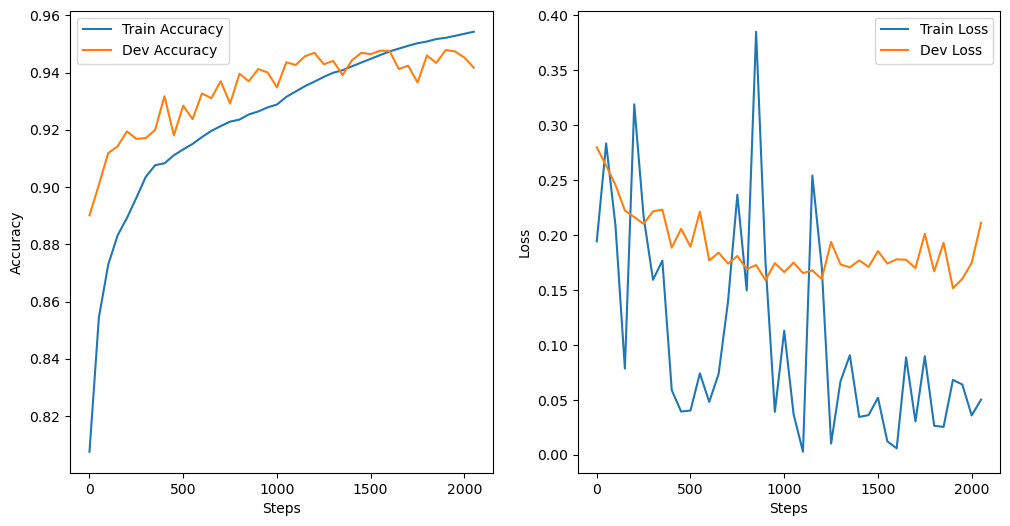

In [107]:
device = torch.device('mps' if torch.cuda.is_available() else 'cpu')
#实例化模型
model = BertClassificationModel()
#调用训练函数进行训练与验证
train_acc_list, train_loss_list, dev_acc_list, dev_loss_list = train(model, train_loader, dev_loader)
plot_accuracy_and_loss(train_acc_list, train_loss_list, dev_acc_list, dev_loss_list)

In [108]:
import torch.nn.functional as F
def predict(model, test_loader, num_samples, labeled=True):
    model.to(device)
    model.eval()
    predicts = []
    predict_probs = []
    with torch.no_grad():
        correct = 0
        total = 0
        for step, batch in enumerate(test_loader):
            if labeled:
                input_ids, token_type_ids, attention_mask, labels = batch
                labels = labels.to(device)
            else:
                input_ids, token_type_ids, attention_mask = batch

            input_ids, token_type_ids, attention_mask = input_ids.to(device), token_type_ids.to(device), attention_mask.to(device)
            out_put = model(input_ids, token_type_ids, attention_mask)
           
            _, predict = torch.max(out_put.data, 1)
 
            pre_numpy = predict.cpu().numpy().tolist()
            predicts.extend(pre_numpy)
            probs = F.softmax(out_put).detach().cpu().numpy().tolist()
            predict_probs.extend(probs)
 
            if labeled:
                correct += (predict == labels).sum().item()
                total += labels.size(0)

        if labeled:
            res = correct / total
            print('predict_Accuracy : {} %'.format(100 * res))
        else:
            res = None

    # 截断预测结果和预测概率，以便它们与数据集中的样本数量相匹配
    predicts = predicts[:num_samples]
    predict_probs = predict_probs[:num_samples]

    # 返回预测结果和预测的概率
    return predicts, predict_probs, res

In [109]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
model = torch.load('../model/span_bert_hide_model1.pkl')
predicts, predict_probs, _ = predict(model, dev_loader, len(dev_data))
true_labels = [label.item() for _, _, _, label in dev_data]
accuracy = accuracy_score(true_labels, predicts)
precision = precision_score(true_labels, predicts, average='binary')
recall = recall_score(true_labels, predicts, average='binary')
f1 = f1_score(true_labels, predicts, average='binary')

print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")


/var/folders/r9/mzznhfxn6f1_pk872fmn29080000gr/T/ipykernel_25604/470291785.py:24: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  probs = F.softmax(out_put).detach().cpu().numpy().tolist()


predict_Accuracy : 94.79043334122662 %
Accuracy: 0.4970
Precision: 0.5010
Recall: 0.4939
F1 Score: 0.4974


In [110]:
#引进训练好的模型进行测试
path = '../model/span_bert_hide_model1.pkl'
Trained_model = torch.load(path)
# 加载无标签数据集的函数
def load_unlabeled_data(path):
    # 使用 pandas 读取 CSV 文件
    df = pd.read_csv(path, encoding='utf-8')

    # 去除表头，将 DataFrame 转换为文本列表
    text_list = df.iloc[:, 0].tolist()

    input_ids, token_type_ids, attention_mask = encoder(max_len=150, vocab_path="vocab.txt", text_list=text_list)
    data = TensorDataset(input_ids, token_type_ids, attention_mask)
    return data
unlabeled_data_path = "../data/zbj_new.csv"
unlabeled_data = load_unlabeled_data(unlabeled_data_path)
unlabeled_loader = DataLoader(dataset=unlabeled_data, batch_size=batch_size, shuffle=False)
# 加载训练好的模型
trained_model_path = '../model/span_bert_hide_model1.pkl'
trained_model = torch.load(trained_model_path)
unlabled_dataset = pd.read_csv('../data/ZBJ_new.csv',encoding='utf-8')
num_samples = len(unlabled_dataset)
predictions, prediction_probs, accuracy = predict(trained_model, unlabeled_loader, num_samples, labeled=False)

/opt/anaconda3/lib/python3.9/site-packages/transformers/tokenization_utils_base.py:1679: FutureWarning: Calling BertTokenizer.from_pretrained() with the path to a single file or url is deprecated and won't be possible anymore in v5. Use a model identifier or the path to a directory instead.
  warnings.warn(
/var/folders/r9/mzznhfxn6f1_pk872fmn29080000gr/T/ipykernel_25604/470291785.py:24: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  probs = F.softmax(out_put).detach().cpu().numpy().tolist()


In [111]:
zbj_new = pd.read_csv("../data/zbj_new.csv", encoding='utf-8')
zbj_new['label'] = predictions

In [112]:
zbj_new

,内容,label
0,八戒，陪你玩了7年了，感觉你现在眼里除了钱就是钱，我们像是被你锁在笼子里开膛破肚取胆汁的月熊...,1
1,哎 现在想进入其实不是好时候了,0
2,打算进去做推广 看见现在这版面 直接退出了,0
3,猪八戒已经不是以前的猪八戒，唯利是图,0
4,是的..猪八戒现在就是个LJ...我也离开了...以前还是挺感激猪八戒的..也赚到了第一桶金...,0
...,...,...
1197,然后细心看了一下那个雇主的任务，所有交稿的人都不合格！！虽然没去看其他人的稿子有没有用过，但...,0
1198,我又看了看这个人的资料，他提出的需求中，别人交稿的基本上没几个是合格的。所以说，这个人骗人已...,0
1199,所以，建议大家在猪八戒做任务的时候注意一些无良雇主。第一，不要看着价格高点儿就做，有些时候很...,0
1200,自言自语了这么多，说出来就舒坦些了。但愿对大家有些帮助，谨防骗子！！！,0


In [114]:
zbj_new.to_csv('../data/zbj_bert_result.csv', index=False, encoding='gb18030')